# Synthetic Data Generation Using Variational Autoencoder

## Importing Required Modules

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

2024-05-02 14:23:09.505897: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 14:23:09.539410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 14:23:10.269835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading and Preparing Data

In [2]:
df = pd.read_csv("card_transaction.v1.csv")


label_encoder = LabelEncoder()

df['Is Fraud?'] = label_encoder.fit_transform(df['Is Fraud?'])
df['Errors?'] = label_encoder.fit_transform(df['Errors?'])
df['Merchant State'] = label_encoder.fit_transform(df['Merchant State'])
df['Merchant City'] = label_encoder.fit_transform(df['Merchant City'])
df['Use Chip'] = label_encoder.fit_transform(df['Use Chip'])

df['Amount'] = df['Amount'].str.replace('$', '').astype('float')

df['Time'] = df['Time'].str[0:2].astype('float')*100+df['Time'].str[-2:].astype('float')
df = df.fillna(df.mean())

In [3]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=37)
# Train on Normal (Is Fraud?=0)
X_train = X_train[X_train['Is Fraud?'] == 0]
# "Is Fraud?" variable is not needed
X_train = X_train.drop(['Is Fraud?'], axis=1)
# test data
y_test = X_test['Is Fraud?']
X_test = X_test.drop(['Is Fraud?'], axis=1)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [4]:
# defining the key parameters
batch_size = 100
original_dim = 14
latent_dim = 2
intermediate_dim = 7
epochs = 10
epsilon_std = 1.0

In [5]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 14)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding (Dense)    │ (None, 7)         │        105 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         16 │ encoding[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log-variance        │ (None, 2)         │         16 │ encoding[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ mean[0][0],       │
│                     │                   │            │ log-variance[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 137 (548.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h (Dense)               │ (None, 7)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_decoded (Dense)            │ (None, 14)             │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (532.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
##########################
# Variational Autoencoder
##########################
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()
# Defina VAE Loss Function
def vae_loss_(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #vae_loss = K.mean(xent_loss + kl_loss)
    return xent_loss

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 2), (None, 2), │           137 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 14)             │           133 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270 (1.05 KB)

 Trainable params: 270 (1.05 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
     
     
# Compile VAE model with custom loss function
vae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# Train the model
history = vae.fit(X_train, X_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(X_test, X_test),
                  verbose=1).history

Epoch 1/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 18s 842us/step - accuracy: 0.2501 - loss: 0.9004 - val_accuracy: 0.3819 - val_loss: 0.8314
Epoch 2/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 18s 860us/step - accuracy: 0.3843 - loss: 0.8296 - val_accuracy: 0.3893 - val_loss: 0.8234
Epoch 3/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 17s 848us/step - accuracy: 0.3905 - loss: 0.8244 - val_accuracy: 0.3952 - val_loss: 0.8216
Epoch 4/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 18s 856us/step - accuracy: 0.3991 - loss: 0.8234 - val_accuracy: 0.3991 - val_loss: 0.8207
Epoch 5/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 17s 852us/step - accuracy: 0.3979 - loss: 0.8218 - val_accuracy: 0.3995 - val_loss: 0.8202
Epoch 6/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 17s 851us/step - accuracy: 0.3934 - loss: 0.8200 - val_accuracy: 0.3885 - val_loss: 0.8192
Epoch 7/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 18s 857us/step - accuracy: 0.3857 - loss: 0.8182 - val_accuracy: 0.3874 - val_loss: 0.8186
Epoch 8/10
20419/20419 ━━━━━━━━━━━━━━━━━━━━ 17s 853us/s

In [10]:
print(z_mean[0], z_log_var[0])

<KerasTensor shape=(2,), dtype=float32, sparse=False, name=keras_tensor_10> <KerasTensor shape=(2,), dtype=float32, sparse=False, name=keras_tensor_11>


In [11]:
num_entities = 2000000
latent_samples = np.random.normal(size=(num_entities, latent_dim))

In [12]:
# Generate synthetic data
def generate_synthetic_data(vae_model, num_samples):
    
    # # Sample from the latent space (normal distribution)
    latent_samples = np.random.normal(size=(num_samples, 2))
    # # Pass through the decoder part of the VAE model
    synthetic_data = decoder.predict(latent_samples)
    return synthetic_data

# Call the function to generate synthetic data
num_synthetic_samples = 2000000  # Define the number of synthetic samples you want to generate
synthetic_data = generate_synthetic_data(vae, num_synthetic_samples)

62500/62500 ━━━━━━━━━━━━━━━━━━━━ 25s 396us/step


### % of duplicate data

In [13]:

# Convert NumPy arrays to DataFrames
df_original = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
df_synthetic = pd.DataFrame(synthetic_data, columns=[f"feature_{i}" for i in range(synthetic_data.shape[1])])

#Concatenate original and synthetic data into a single DataFrame
df_combined = pd.concat([df_original, df_synthetic])

# Calculate the number of duplicate samples in each dataset
num_duplicates_original = df_original.duplicated().sum()
num_duplicates_synthetic = df_synthetic.duplicated().sum()
num_duplicates_combined = df_combined.duplicated().sum()

# Calculate the total number of samples in each dataset
total_samples_original = len(df_original)
total_samples_synthetic = len(df_synthetic)
total_samples_combined = len(df_combined)

# Calculate the percentage of duplicate data in each dataset
percentage_duplicates_original = (num_duplicates_original / total_samples_original) * 100
percentage_duplicates_synthetic = (num_duplicates_synthetic / total_samples_synthetic) * 100
percentage_duplicates_combined = (num_duplicates_combined / total_samples_combined) * 100

# Print the results
print("Percentage of duplicate data in original training data:", percentage_duplicates_original)
print("Percentage of duplicate data in generated synthetic data:", percentage_duplicates_synthetic)
print("Percentage of duplicate data in combined dataset:", percentage_duplicates_combined)


Percentage of duplicate data in original training data: 0.00019590423025799607
Percentage of duplicate data in generated synthetic data: 0.0
Percentage of duplicate data in combined dataset: 9.896546451667493e-05


### Data Distribution between Real and Synthetic Data

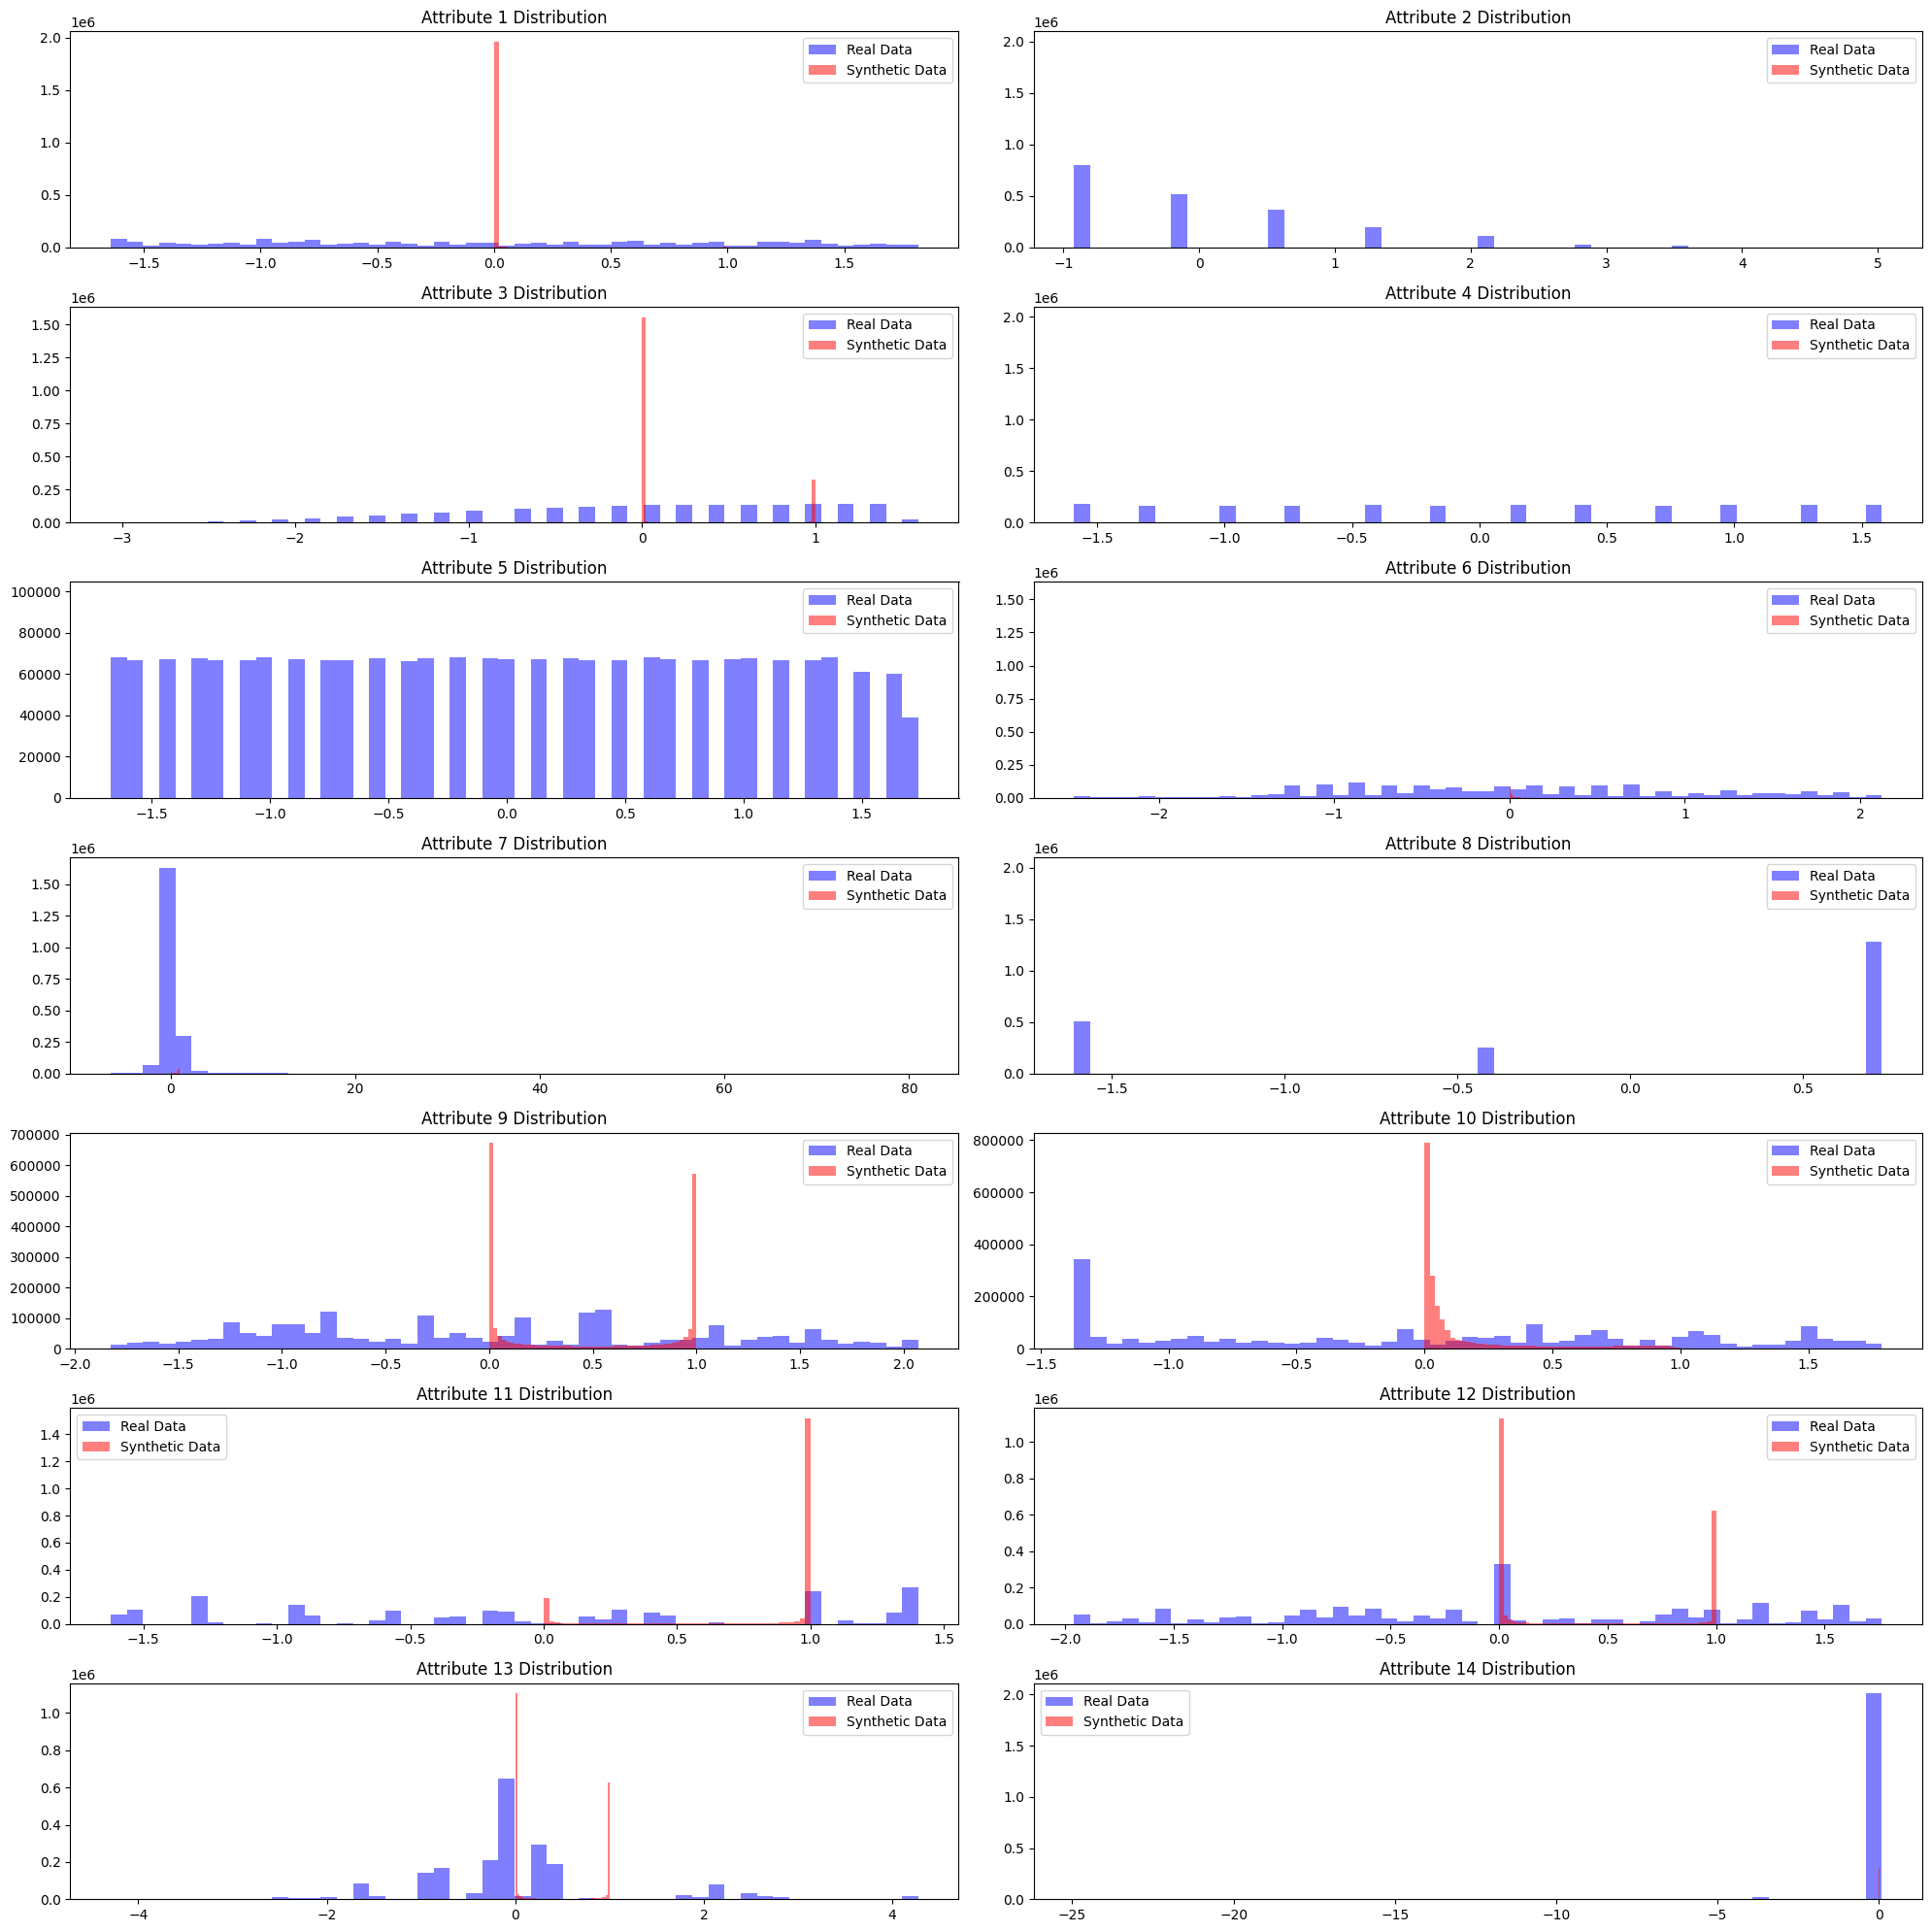

In [14]:
import matplotlib.pyplot as plt

# Plot histograms for each attribute
plt.figure(figsize=(20, 20))
for i in range(14):
    plt.subplot(7, 2, i+1)
    plt.hist(df_original.iloc[:, i], bins=50, alpha=0.5, label='Real Data', color='blue')
    plt.hist(df_synthetic.iloc[:, i], bins=50, alpha=0.5, label='Synthetic Data', color='red')
    plt.title(f'Attribute {i+1} Distribution')
    plt.legend()
plt.tight_layout()
plt.show()

From the above, we see that
- Attributes 4, 5, 7, 8, 9, 10, 12, 14 are showing similar behaviour between real data and synthetic data
- For remaining attributes, the synthetic data seems to be concentrated to some area

### Joint Distribution

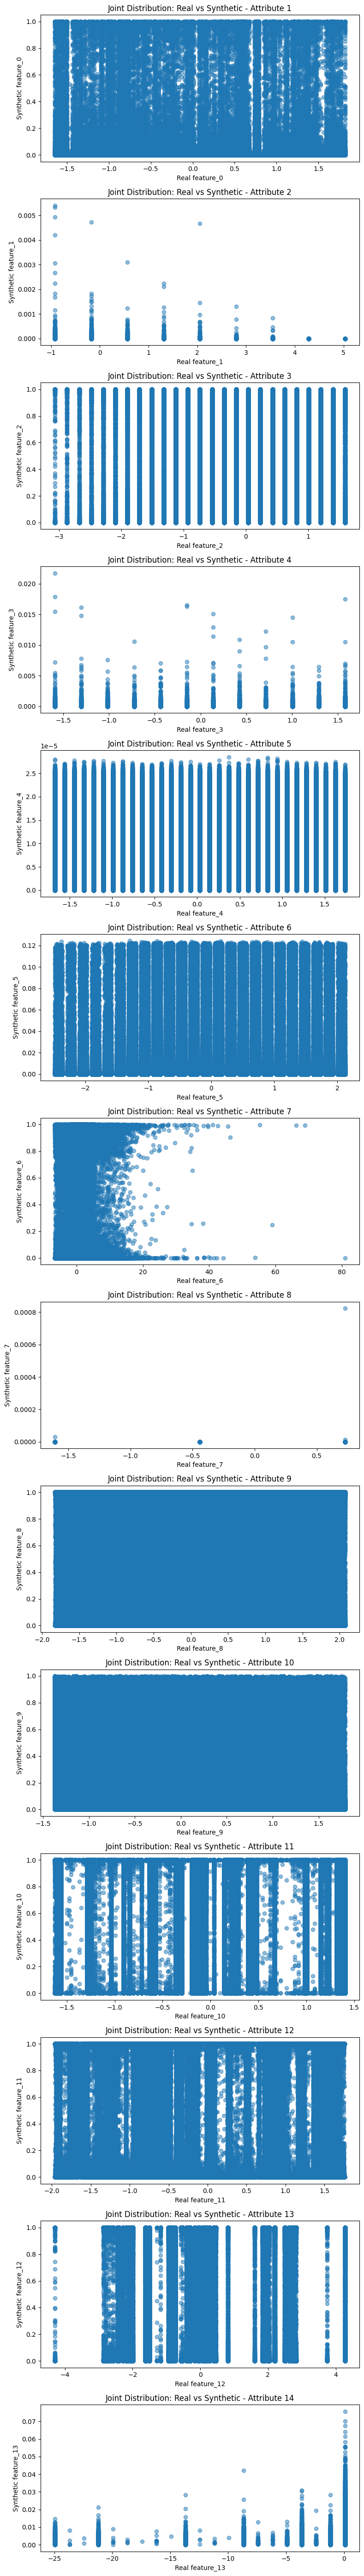

In [18]:
num_attributes = len(df_original.columns)

# Set the size of the figure
fig, axs = plt.subplots(num_attributes, 1, figsize=(8, 4*num_attributes))
df_original = df_original.head(2000000)
# Loop through each attribute and plot the joint distribution
for i, attribute in enumerate(df_original.columns):
    axs[i].scatter(df_original[attribute], df_synthetic[attribute], alpha=0.5)
    axs[i].set_xlabel(f'Real {attribute}')
    axs[i].set_ylabel(f'Synthetic {attribute}')
    axs[i].set_title(f'Joint Distribution: Real vs Synthetic - Attribute {i+1}')

plt.tight_layout()
plt.show()